# Machine Learning Models in Radiation Oncology Quality Assurance

This notebook shows the applications of various machine learning models to a data regarding radiation treatment fields in oncology. This data is also used in my 4th year research project for MA489: Honours Seminar in which I conducted 8 months of research under Dr. Xu (Sunny) Wang (Wilfrid Laurier University) and Dr. Harald Keller (Princess Margaret Hospital). 

The radiation oncology treats cancer by using radiation beams targetting tumors. The photon beams are aimed at cancer cells and are adminstered by a radiation machine (called a linear accelerator or LINAC, for short) that travels 360 degrees around the patient's body. The shape of the beam is controlled by the multi-leaf collimator which consists of several metal "leaves" that move in and out of the beam to adjust it's shape. The administration of the beam is planned by a tratment plannning software to determines a homogeneous dose to the target while minimizing the dose recieved by surrounding organs. Before the treatment can be administered to the patient it must pass a quality assurance process first. The radiation beam is applied to a detector to test the correctness of the dose calculations and the ability of the LINAC to administer the treatment plan. QA quantifies the difference between the expected dose distribution from the treatment plan and the measured dose distribution on the detector. The QA passing rate determines whether the plan can be administered to the patient. 

My data holds the features of the radiation beam. It contains the leaf positions of the multi leaf collimator for every second degree of rotation. Knowing the leaf positions allow us to determine the shape of the beam that is being administered to the detector. There exists snapshots of the leaf positions at every second degree of rotation, which are called control points or segments. In a normal, 360 degree, rotation, a treatment would contain 180 control points. I have created a matrix representation of the treatment field whose columns represent the control points and rows represent the individual leaf positions. This matrix, and the features engineered from this matrix, will serve as predictor variables and the target variable will be the QA pass rate of the field (or whether or not the field passed QA). 

In [1]:
# Imports 
import os, pandas as pd, numpy as np

In [2]:
# Object Oriented Framework for handling treatment field data

class Field():

    def __init__(self, file_name):

        self.file = file_name
        field_info = self.__import_field(file_name)
        self.field_ID = field_info["fieldId"]
        self.name = field_info["name"]
        self.description = field_info["description"]
        self.machine_type = field_info["machineType"]
        self.machine_name = field_info["machineName"]
        self.type = field_info["type"]
        self.mq_type = field_info["mqType"]
        self.isocentre = field_info["isocentre"]
        self.beam_meterset = field_info["beamMeterset"]
        self.mq_control_points = field_info["mqControlPoints"]
        self.beam_energy = field_info["beamEnergy"]
        self.is_fff = field_info["isFff"]
        self.bolus_status = field_info["bolusStatus"]
        self.has_bolus = field_info["hasBolus"]
        self.__set_leaf_activity_interval()
        self.__create_matrix()
        self.leaf_width = 0.5
        areas_matrix = (self.matrixA + self.matrixB)*self.leaf_width
        self.__set_gantry_total_areas(areas_matrix)
        self.__set_span()
        self.__set_MU()
        self.__set_circumference()
        self.__set_MCS()

    
    def __import_field(self, file_name):
        """
        imports the field information from the file name

        ------------------------------------------------
        Parameters
            file_name (str) - the name of the file to import from

        Returns
            field_info (dict) - the information for the field

        """
        import json

        if not isinstance(file_name, str):
            print("Error __import_field: file_name must be a string")

        if not file_name.endswith(".json"):
            print("Error __import_field: make sure file is json format")

        with open(file_name, "r") as f:
            field_info = json.load(f)

        return field_info

    
    def __create_matrix(self):
        """
        converts the field information from dictionairy for to a matrix with
        gantry angles indexing the columns and leaf numbers indexing the rows. 
        Adds the matrices to the field object.

        ---------------------------------------------------------------------
        Attributes
            None
        Returns 
            None
        """

        import pandas as pd

        matrixA = pd.DataFrame()
        matrixB = pd.DataFrame()

        index = []

        for segment in self.mq_control_points:
            index.append(segment["gantryAngle"])
            matrixA = pd.concat([matrixA, pd.Series(segment["leafSetA"])], axis = 1)
            matrixB = pd.concat([matrixB, pd.Series(segment["leafSetB"])], axis = 1)


        self.columns = index
        matrixA.columns = index
        matrixB.columns = index
        self.matrixA = matrixA.loc[self.active_leaf_start:self.active_leaf_end]
        self.matrixB = matrixB.loc[self.active_leaf_start:self.active_leaf_end]

        return
    
    def __set_MU(self):
        import pandas as pd
        cum_ms = []

        total_ms = self.beam_meterset
        for aperature in self.mq_control_points:
            cum_ms.append(aperature['cumulativeMetersetWeight'])

        cum_ms = pd.Series(cum_ms, index = self.columns)
        prop_ms = cum_ms.diff()
        prop_ms[self.columns[0]] = 0

        self.aperature_ms = prop_ms*total_ms 

    def __set_gantry_total_areas(self, areas_matrix):
        self.gantry_total_areas = areas_matrix.sum()
        return 
    
    def __set_leaf_activity_interval(self):
        active_leaf_start = int(self.mq_control_points[0]["mlcLeaves"]//2 - self.mq_control_points[0]["collimatorX1"]/0.5) # first leaf outside jaw
        active_leaf_end = int(self.mq_control_points[0]["mlcLeaves"]//2 + self.mq_control_points[0]["collimatorX2"]/0.5)
        
        self.active_leaf_start = active_leaf_start
        self.active_leaf_end = active_leaf_end

        return
    
    def __calcAlpha(self, ordinate, abscissa):
        import math
        # the 'ordinate' is the vertical, the 'abscissa' is the horizontal axis
        
        if ordinate == 0 and abscissa == 0:
            alpha = 0
        elif ordinate > 0 and abscissa == 0:
            alpha = 90
        elif ordinate < 0 and abscissa == 0:
            alpha = 270
        
        elif ordinate >= 0 and abscissa > 0:
            alpha= math.degrees(math.atan(ordinate/abscissa))
        elif ordinate >= 0 and abscissa < 0:
            alpha= math.degrees(math.atan(ordinate/abscissa)) + 180
        elif ordinate <= 0 and abscissa < 0:
            alpha= math.degrees(math.atan(ordinate/abscissa)) + 180    
        elif ordinate <= 0 and abscissa > 0:
            alpha= math.degrees(math.atan(ordinate/abscissa)) + 360
        
        return alpha

    def __calc_span(self, machine_type, collimatorAngle, X1, X2, Y1 = None, Y2 = None):
        import math
        # machine_type == Agility: X1, X2 are the "top" and "bottom" jaws, "Y1" and "Y2" are the imaginary left and right jaws (to be replaced by the maxima of LeafbankB and LeafbankA respectively)

        if machine_type == "Agility":
        
            alpha1 = self.__calcAlpha(Y1, X1) #UR
            alpha2 = self.__calcAlpha(-Y2, X1)  #UL
            alpha3 = self.__calcAlpha(-Y2, -X2) #BL
            alpha4 = self.__calcAlpha(Y1, -X2) #BR
            
            radius2 = math.sqrt(math.pow(X1,2)+math.pow(Y2,2)) #UR
            radius1 = math.sqrt(math.pow(X1,2)+math.pow(-Y1,2)) #UL
            radius4 = math.sqrt(math.pow(-X2,2)+math.pow(-Y1,2)) #BL
            radius3 = math.sqrt(math.pow(-X2,2)+math.pow(Y2,2)) #BR
            
        elif machine_type == "TrueBeam":
            alpha1 = self.__calcAlpha(X2, Y2) #UR
            alpha2 = self.__calcAlpha(-X1, Y2)  #UL
            alpha3 = self.__calcAlpha(-X1, -Y1) #BL
            alpha4 = self.__calcAlpha(X2, -Y1) #BR
            
            radius1 = math.sqrt(math.pow(Y2,2)+math.pow(X2,2)) #UR
            radius2 = math.sqrt(math.pow(Y2,2)+math.pow(-X1,2)) #UL
            radius3 = math.sqrt(math.pow(-Y1,2)+math.pow(-X1,2)) #BL
            radius4 = math.sqrt(math.pow(-Y1,2)+math.pow(X2,2)) #BR            
            
        ### calculate the rotated field edges
        # collimatorAngle needs to be in radians units
        UR_rotated = [radius1*math.cos(math.radians(alpha1)+collimatorAngle), radius1*math.sin(math.radians(alpha1)+collimatorAngle)]
        UL_rotated = [radius2*math.cos(math.radians(alpha2)+collimatorAngle), radius2*math.sin(math.radians(alpha2)+collimatorAngle)]
        BL_rotated = [radius3*math.cos(math.radians(alpha3)+collimatorAngle), radius3*math.sin(math.radians(alpha3)+collimatorAngle)]
        BR_rotated = [radius4*math.cos(math.radians(alpha4)+collimatorAngle), radius4*math.sin(math.radians(alpha4)+collimatorAngle)]
        
        field_rotated = [UR_rotated, UL_rotated, BL_rotated, BR_rotated]
        field_rotated_ordinate = [corner[1] for corner in field_rotated]
        
        span = max(field_rotated_ordinate) - min(field_rotated_ordinate)
            #print('span = ', span)
            
        return span

    def __set_span(self):
        import math
        
        num_cp = len(self.mq_control_points)
        max_span = 0

        spans = []

        for i in range(num_cp):
            max_span = 0
            if self.machine_type == "Agility":
                Y1 = self.matrixA.max().max()
                Y2 = self.matrixB.max().max()
            else:
                Y1 = self.mq_control_points[0]["collimatorY1"]
                Y2 = self.mq_control_points[0]["collimatorY2"]
            X1 = self.mq_control_points[0]["collimatorX1"]
            X2 = self.mq_control_points[0]["collimatorX2"]
            collimatorAngle = self.mq_control_points[i]["collimatorAngle"]*math.pi/180
            span = self.__calc_span(self.machine_type, collimatorAngle,
                                    X1, X2, Y1, Y2)
            spans.append(span)
            
        import pandas as pd
        self.spans = pd.Series(spans, index = self.columns)

    def __set_circumference(self):
        matrixA = self.matrixA.T
        rightA = matrixA.iloc[:,1:]
        rightA.columns = matrixA.columns[:-1]

        leftA = matrixA.iloc[:, :-1]
        leftA.columns = matrixA.columns[1:]

        left_diffA = abs(matrixA.iloc[:,1:] - leftA) 
        left_diffA[self.active_leaf_start] = 0

        right_diffA = abs(matrixA.iloc[:,:-1] - rightA)
        right_diffA[self.active_leaf_end] = 0 

        circumferenceA  = 1/2*(left_diffA+ right_diffA) + self.leaf_width

        matrixB = self.matrixB.T
        rightB = matrixB.iloc[:,1:]
        rightB.columns = matrixB.columns[:-1]

        leftB = matrixB.iloc[:, :-1]
        leftB.columns = matrixB.columns[1:]

        left_diffB = abs(matrixB.iloc[:,1:] - leftB) 
        left_diffB[self.active_leaf_start] = 0

        right_diffB = abs(matrixB.iloc[:,:-1] - rightB)
        right_diffB[self.active_leaf_end] = 0 

        circumferenceB  = 1/2*(left_diffB+ right_diffB) + self.leaf_width

        total_circumference = circumferenceA + circumferenceB

        aperature_circumference = total_circumference.T.sum() + self.matrixA.iloc[0] + self.matrixB.iloc[0] + self.matrixA.iloc[-1] + self.matrixB.iloc[-1]

        self.aperature_circumference = aperature_circumference

    def __set_MCS(self):
        
        pos_a = self.matrixA
        pos_b = self.matrixB

        pos_max_a = pos_a.max() - pos_a.min()
        pos_max_b = pos_b.max() - pos_b.min()
        n = pos_a.shape[0]

        lsv_a = (pos_max_a - pos_a.diff()).sum()/((n)*pos_max_a)
        lsv_b = (pos_max_b - pos_b.diff()).sum()/((n)*pos_max_b)

        lsv_segment = lsv_a * lsv_b

        aav = (pos_a + pos_b).sum()/(pos_a.T.max() + pos_b.T.max()).sum()

        mcs_beam = (aav * lsv_segment * self.aperature_ms).sum()

        aperature_mcs = aav * lsv_segment * self.aperature_ms
        self.aperature_mcs = aperature_mcs.fillna(0)
        self.overall_mcs = mcs_beam

In the following code chunk, I will read in the treatment data and calculate metrics for the fields. Some are as simple as the area of the opening created by the mlc leaves for the beam to pass through, others like modulation complexity score are a little more nuanced calculations. For more information regarding the metrics see my paper [Insert link here]. 

In [3]:
dates = "C:\\Users\\gfman\\Documents\\RadiationData" # folder that contains all radiation fields
master = pd.DataFrame()
for date in os.listdir(dates): # iterate through each day of saved data

    files = dates + "/" + date # folder that contains all the fields for a select day

    metadata = pd.read_json(files + "/" + os.listdir(files)[-1]).set_index("FieldID") # read the metadata of the daily files

    mcs = []
    circumferences = []
    areas = []
    spans = []
    coa = []
    for file in os.listdir(files): # iterate over every file from the day
        if "MetaData" in file:
            continue
        filename = files + "/" + file # create file name

        try:
            field = Field(filename) # try to make a Field object from the radiation field
        except:
            areas.append(np.nan)
            circumferences.append(np.nan)
            mcs.append(np.nan)
            spans.append(np.nan)
            coa.append(np.nan)
            continue

        areas.append(field.gantry_total_areas.mean())
        circumferences.append(field.aperature_circumference.mean())
        mcs.append(field.overall_mcs)
        spans.append(field.spans.max())
        coa.append(areas[-1]/circumferences[-1])

    metadata["Area"] = areas
    metadata["Circumference"] = circumferences
    metadata["MCS"] = mcs
    metadata['Span'] = spans
    metadata["CoA"] = coa

    master = pd.concat([master, metadata])

master.dropna(inplace=True)
master.head()

Error __import_field: make sure file is json format


,QADate,Unit,Energy,MU,DPF,ADPass,RDPass,AD,RD,D4DD,D4DTA,D4Gamma,Area,Circumference,MCS,Span,CoA,PID
FieldID,,,,,,,,,,,,,,,,,,
2393893,11/07/2023,EV06,6FFF,1099.0,750,76,95,93.0,100.0,0.0,0.0,0.0,18.533026,29.587632,39.853673,11.827242,0.626377,1.0
2393892,11/07/2023,EV06,6FFF,826.0,750,76,95,90.9,99.2,0.0,0.0,0.0,18.451250,28.622895,34.024564,12.371420,0.644633,1.0
2393785,11/07/2023,EV06,6FFF,5904.0,3400,76,95,83.0,99.2,0.0,0.0,0.0,13.118056,25.059000,264.879995,17.459732,0.523487,13.0
2393904,11/07/2023,EV06,6FFF,7174.0,3400,76,95,84.7,97.9,0.0,0.0,0.0,17.474194,24.502222,170.504328,19.022270,0.713168,0.0
2393879,11/07/2023,EV06,6FFF,2746.0,900,75,90,82.1,98.5,0.0,0.0,0.0,162.353972,103.159667,195.148731,27.353792,1.573812,5.0


Each data point represents a treatment field that has been tested on the quality assurance detector. The field is indexed by the FieldID. The QA pass rate is represented by AD and represents what precent of detector passed the QA. The field fails QA if the AD is less than the ADPass. We can tell what day the treatment was tested with QADate and which patient that day recieved the treatment with PID.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = StandardScaler().fit_transform(X = master[["Area", "Circumference", "MCS", "Span", "CoA", "MU"]])
y = master["AD"] > master["ADPass"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train = pd.DataFrame(X_train, index = y_train.index, columns = ["Area", "Circumference", "MCS", "Span", "CoA", "MU"])
X_test = pd.DataFrame(X_test, columns = ["Area", "Circumference", "MCS", "Span", "CoA", "MU"])

## Random Forest Model
Tree based methods have a decision structure that may prove complimentary to health care problems.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV


In [6]:
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators':[5,10,15,20],
    'max_depth':[2,5,7,9]
}

grid_clf = GridSearchCV(rfc, param_grid, cv=10)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 20}

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

Training ROC AUC 0.5


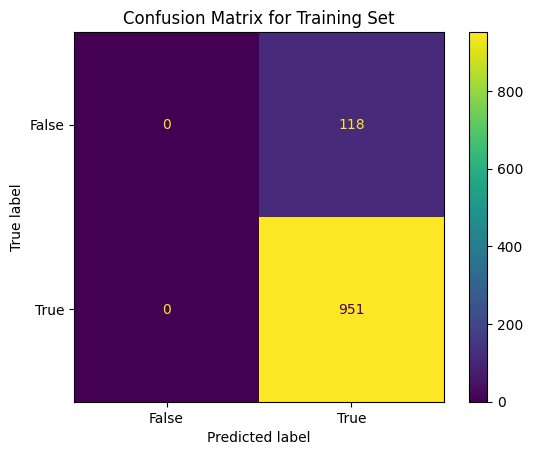

In [8]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=2)
rfc.fit(X_train, y_train)

pred_rf = rfc.predict(X_train)

print("Training ROC AUC", roc_auc_score(y_train, pred_rf))
cm1 = ConfusionMatrixDisplay.from_predictions(y_train, pred_rf)
cm1.ax_.set_title("Confusion Matrix for Training Set")
plt.show()

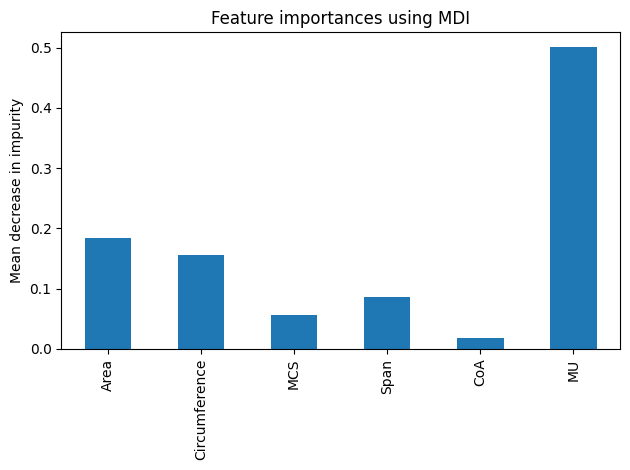

In [9]:
# Feature Importance
feature_names = X_train.columns
importances = rfc.feature_importances_

import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Boosting

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
abc = AdaBoostClassifier(algorithm="SAMME")
param_grid = {
    'learning_rate':[0.001,0.01,0.05,0.1],
    'n_estimators':[5,25,125,625],
    "estimator":[RidgeClassifier(), LogisticRegression(),DecisionTreeClassifier(max_depth=2)]
}

grid_abc = GridSearchCV(abc, param_grid, cv=10)
grid_abc.fit(X_train, y_train)
grid_abc.best_params_

{'estimator': RidgeClassifier(), 'learning_rate': 0.001, 'n_estimators': 5}

Training ROC AUC 0.5


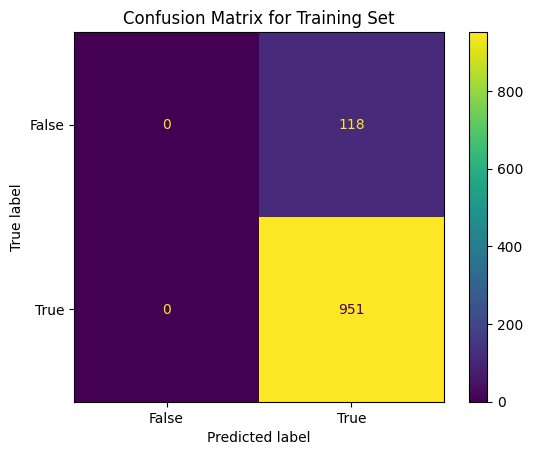

In [11]:
abc = AdaBoostClassifier(algorithm="SAMME", n_estimators=5, learning_rate=0.001, estimator = RidgeClassifier())
abc.fit(X_train, y_train)

pred_boosting = abc.predict(X_train)

print("Training ROC AUC", roc_auc_score(y_train, pred_boosting))
cm1 = ConfusionMatrixDisplay.from_predictions(y_train, pred_boosting)
cm1.ax_.set_title("Confusion Matrix for Training Set")
plt.show()

In [12]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [13]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/2769225986368/ -->

In [14]:
show(ebm.explain_local(X_test[:5], y_test[:5]), 0)

<!-- http://127.0.0.1:7001/2769240133360/ -->

## Recurrent Neural Network

In [18]:
# 3D Tensor with complexity metrics

features = [] # list for storing complexity metrics
AD = [] # list for storing AD
x = 0

dates = "C:\\Users\\gfman\\Documents\\RadiationData" # folder that contains all radiation fields

for date in os.listdir(dates): # iterate through each day of saved data

    files = dates + "/" + date # folder that contains all the fields for a select day

    metadata = pd.read_json(files + "/" + os.listdir(files)[-1]).set_index("FieldID") # read the metadata of the daily files

    for file in os.listdir(files): # iterate over every file from the day
        if "MetaData" in file:
            continue
        filename = files + "/" + file # create file name

        try:
            field = Field(filename) # try to make a Field object from the radiation field
        except:
            continue
        areas = field.gantry_total_areas
        circumferences = field.aperature_circumference
        metric_units = field.aperature_ms
        coas = circumferences/areas*metric_units
        mcs = field.aperature_mcs
        spans = field.spans
        field_features = []
        for i in range(180):
            if i >= len(areas):
                area = areas.mean()
                circumference = circumferences.mean()
                mu = metric_units.mean()
                coa = coas.mean()
                modulation_cs = mcs.mean()
                span = spans.mean()
            else:
                area = areas.iloc[i]
                circumference = circumferences.iloc[i]
                mu = metric_units.iloc[i]
                coa = coas.iloc[i]
                modulation_cs = mcs.iloc[i]
                span = spans.iloc[i]
            field_features.append([area,circumference, mu, coa, modulation_cs, span])
           
        features.append(field_features)
       
        AD.append(metadata.loc[field.field_ID, "AD"] < metadata.loc[field.field_ID, "ADPass"]) # append AD from metadata to list

Error __import_field: make sure file is json format


In [19]:
features = np.array(features)
AD = np.array(AD)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, AD, test_size= 0.25)

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences= True, input_shape=(180,6)))
model.add(LSTM(units=50))
model.add(Dense(units = 2**5))
model.add(Dense(units = 2**2))
#model.add(LSTM(units=50))
model.add(Dense(units=1, activation = 'sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ["auc"])

# Train the model
model.fit(X_train2, y_train2, epochs=10, batch_size=32, validation_data=(X_test2, y_test2))


Epoch 1/10


c:\Users\gfman\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc: 0.5839 - loss: 0.4193 - val_auc: 0.7355 - val_loss: 0.3158
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - auc: 0.7206 - loss: 0.3284 - val_auc: 0.7510 - val_loss: 0.3243
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - auc: 0.7121 - loss: 0.3374 - val_auc: 0.8072 - val_loss: 0.2905
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - auc: 0.8112 - loss: 0.3011 - val_auc: 0.8189 - val_loss: 0.2742
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - auc: 0.8630 - loss: 0.2687 - val_auc: 0.8563 - val_loss: 0.2618
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - auc: 0.8454 - loss: 0.2730 - val_auc: 0.8512 - val_loss: 0.2639
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - auc: 0.8627 - loss: 0.2603 - val_auc: 0.8633 - val_loss: 0.2467
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - auc: 0.8700 - loss: 0.2597 - val_auc: 0.8628 - val_loss: 0.2508
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - auc: 0.8533 - loss:

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Training ROC AUC 0.6063650306748467


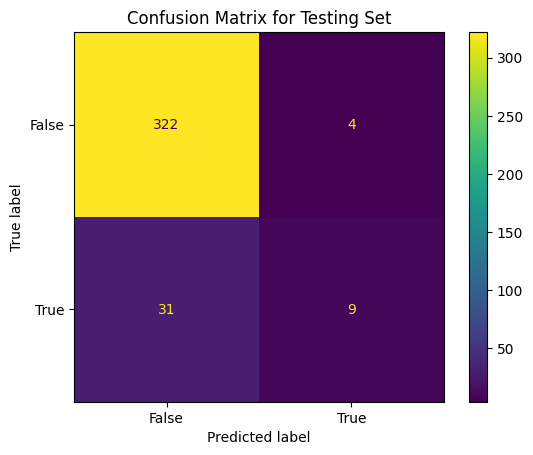

In [21]:
preds_rnn2 = model.predict(X_test2)
print("Training ROC AUC", roc_auc_score(y_test2, preds_rnn2>0.5))
cm1 = ConfusionMatrixDisplay.from_predictions(y_test2, preds_rnn2>0.5)
cm1.ax_.set_title("Confusion Matrix for Testing Set")
plt.show()

In [22]:
import shap
shap.initjs()

In [26]:
explainer = shap.DeepExplainer(model, X_train2)
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2, plot_type="bar")


c:\Users\gfman\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



AttributeError: in user code:

    File "c:\Users\gfman\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py", line 239, in grad_graph  *
        phase = tf.keras.backend.learning_phase()

    AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'learning_phase'


It turns out shap is not yet compatible with keras LSTM. I tried debugging this but I can't seem to figure it out :/